In [50]:
import os
import json
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# !conda update -n base -c defaults conda
# !conda install seaborn

In [58]:
result_dir = '../../output/hetPQA/exp02/04_04_2023-19_52_23/'

In [59]:
def MRR(result_dts):
    reciprocals = []
    for result_dt in result_dts:
        true_positive = (set(result_dt["actual_ctx_ids"]) & set(result_dt["pred_ctx_ids"]))
        if len(true_positive):
            first_rank = min([result_dt["pred_ctx_ids"].index(idx) for idx in true_positive]) + 1
            reciprocal = 1 / first_rank
        else:
            reciprocal = 0
        result_dt["rr"] = reciprocal
        reciprocals.append(reciprocal)
    count = len(reciprocals)
    mean_rr = sum(reciprocals)/count if count else None
    return mean_rr, result_dts

In [54]:
rank_file_path = os.path.join(result_dir, 'rank_score_ids.jsonl')
result_dts = []
with open(rank_file_path, 'r') as fin:
    for line in fin:
        json_dt = json.loads(line.strip())
        result_dts.append(json_dt)
        
mrr, result_dts = MRR(result_dts)
print(f'Mean reciprocal rank: {mrr}')

Mean reciprocal rank: 0.8289999076246205


In [60]:
df = pd.DataFrame(result_dts)
df.head()

,qid,source,scores,pred_ctx_ids,actual_ctx_ids,rr
0,8,attribute,"[81.55857849121094, 53.98442840576172, 51.0949...","[123917, 141841, 23841, 45119, 50989, 42133, 1...",[123917],1.0
1,17,attribute,"[54.50217819213867, 52.6817512512207, 52.50930...","[45119, 146264, 134904, 145969, 14068, 2055, 6...",[146264],0.5
2,25,attribute,"[71.90149688720703, 49.93775177001953, 47.5014...","[99117, 41571, 4623, 131188, 35404, 136384, 25...",[99117],1.0
3,28,attribute,"[83.82231140136719, 58.26805877685547, 57.1513...","[131193, 75250, 134102, 148908, 70315, 23975, ...",[131193],1.0
4,37,attribute,"[72.64936065673828, 53.7113151550293, 52.94037...","[146272, 147180, 33612, 106275, 47591, 32472, ...",[146272],1.0


In [61]:
def unique(x):
    return len(x.unique())
source_df = df[['qid', 'source', 'rr']].groupby('source').aggregate({'qid':['count', unique], 'rr':['min', 'max', 'mean']})
source_df.columns = ['_'.join(vals) for vals in source_df.columns.to_flat_index()]
source_df

,qid_count,qid_unique,rr_min,rr_max,rr_mean
source,,,,,
CQA,1958,1958,0.012048,1.0,0.663509
Desc,2021,1070,0.062500,1.0,0.998464
OSP,147,126,0.043478,1.0,0.691583
attribute,1001,1001,0.052632,1.0,0.913824
bullet,692,692,0.090909,1.0,0.867354
review,1696,1696,0.050000,1.0,0.764315


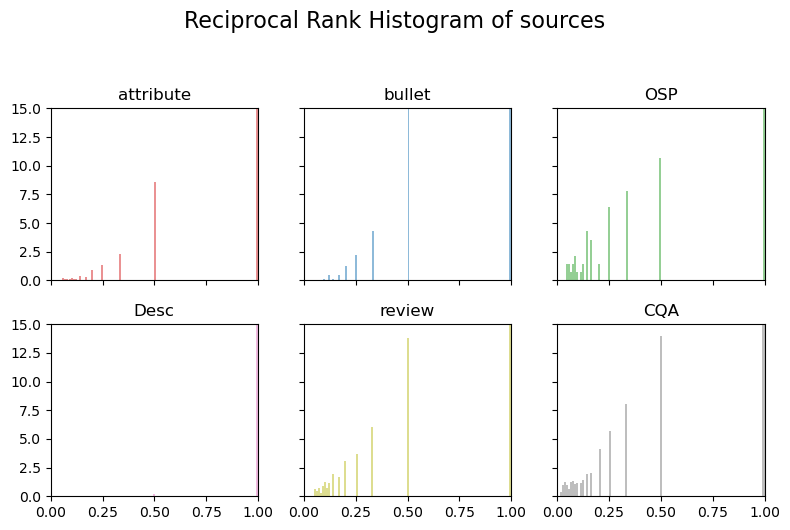

In [74]:
# Plot
fig, axes = plt.subplots(2, 3, figsize=(8,5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive', 'tab:gray']

for i, (ax, source) in enumerate(zip(axes.flatten(), df.source.unique())):
    x = df.loc[df.source==source, 'rr']
    ax.hist(x, alpha=0.5, bins=100, density=True, stacked=True, label=str(source), color=colors[i])
    ax.set_title(source)

plt.suptitle('Reciprocal Rank Histogram of sources', y=1.05, size=16)
ax.set_xlim(0, 1); ax.set_ylim(0, 15);
plt.tight_layout();

In [ ]:
# plt.subplots(figsize=(7,6), dpi=100)
# sns.distplot( df.loc[df.source=='CQA', "rr"] , color="gray", label="CQA")
# sns.distplot( df.loc[df.source=='Desc', "rr"] , color="orange", label="Desc")
# sns.distplot( df.loc[df.source=='OSP', "rr"] , color="pink", label="OSP")
# sns.distplot( df.loc[df.source=='attribute', "rr"] , color="red", label="attribute")
# sns.distplot( df.loc[df.source=='bullet', "rr"] , color="olive", label="bullet")
# sns.distplot( df.loc[df.source=='review', "rr"] , color="green", label="review")

# plt.title('Reciprocal Rank Histogram')
# plt.legend()

In [79]:
import collections
test_path = '../../data/evidence_ranking/grouped/test.json'
with open(test_path, 'r') as fin:
    test_samples = json.load(fin)

test_dt = {}
qid_src_counter = collections.Counter()
for sample in test_samples:
    if sample['positive_ctxs']:
        source = sample['positive_ctxs'][0]['source']
        count = qid_src_counter[(sample['qid'], source)] + 1
        qid_src_counter[(sample['qid'], source)] = count
        qid_src_count = sample['qid'] + '_' + source + '_' + str(count)
        test_dt[qid_src_count] = sample

most_common = qid_src_counter.most_common(5)
print(most_common)

[(('671', 'Desc'), 12), (('1715', 'Desc'), 12), (('2352', 'Desc'), 12), (('390', 'Desc'), 10), (('634', 'Desc'), 10)]


In [75]:
def get_bad_samples(count, df):
    
    sources = list(df['source'].unique())
    for source in sources:
        cqa_df = df[df[source]=='CQA']
        cqa_low_df = cqa_df[cqa_df['rr']<=0.2]
        print(f'Size of CQA: {len(cqa_df)}, CQA_low: {len(cqa_low_df)}')
        cqa_low_df.sort_values(by=['rr'], inplace=True)
        

Size of CQA: 1958, CQA_low: 382


C:\Users\bbiswas\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,qid,source,scores,pred_ctx_ids,actual_ctx_ids,rr
7230,1090,CQA,"[69.59332275390625, 63.061729431152344, 60.929...","[10679, 96612, 49623, 18494, 149287, 56197, 53...",[20974],0.012048
5705,135,CQA,"[68.0343246459961, 64.28477478027344, 63.67087...","[23179, 129747, 34308, 85633, 38503, 44356, 11...",[99508],0.016667
7275,915,CQA,"[61.25248718261719, 59.43944549560547, 58.8207...","[111301, 78125, 12794, 121394, 82193, 144917, ...","[13982, 82405]",0.018519
6084,2556,CQA,"[67.098876953125, 54.84682083129883, 53.235469...","[16971, 127000, 118123, 123986, 5995, 5645, 13...",[141509],0.018868
5803,2571,CQA,"[51.77345275878906, 50.18119812011719, 49.0549...","[81822, 31208, 128094, 90901, 59703, 84530, 51...",[18539],0.018868
